In [1]:
from anndata import AnnData
import scanpy as sc
import pandas as pd
import anndata as ad

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy

from pygam import GAM, s, te

from sklearn.neighbors import NearestNeighbors


Set parameters

In [2]:
neighbors = 15

colors = {"DCT": "#800515",
               "Endothelium": "#7ae031",
               "UB_CT": "black",
               "Podocyte": "#ad9c00", 
               "Stroma": "#794b82",
               "NPC": "#ff8000", 
               "PT": "#ff00d4", 
               "Int": "#698cff",
               "Ureth": "#d47222", 
               "PEC": "#ff0011", 
               "LOH": "#235e00",
               "Immune Cells": '#757575',
         }

In [3]:
adata = sc.read_h5ad("/home/levinsj/spatial/adata/project_Files/Fetal/model2/fetal_PostSCANVI_imputedExpression_neighborhoods.h5ad")
print(adata)

AnnData object with n_obs × n_vars = 377959 × 24485
    obs: 'sample', 'phase', 'type', 'cellType', 'cellType3', 'tech', 'cellType_CosMx_1', 'leiden', 'fov', 'cell_ID', 'pct_counts_mt', 'pct_nuc', 'total_counts', 'nCount_RNA', 'n_genes_by_counts', 'CenterX_global_px', 'CenterY_global_px', 'Area', 'Count_percentile', 'Mean.DAPI', 'Max.DAPI', 'G2M_score', 'S_score', 'gAge', 'AllCounts', '_scvi_batch', '_scvi_labels', 'mean_distance', 'worst_pct', 'cellType_SCANVI', 'leiden_sub18', 'neighbors', 'Endothelium_neighbor', 'UB_CT_neighbor', 'Stroma_neighbor', 'Podocyte_neighbor', 'PT_neighbor', 'PEC_neighbor', 'LOH_neighbor', 'Int_neighbor', 'DCT_neighbor', 'Immune Cells_neighbor', 'Ureth_neighbor', 'DCT_absorbtion_SCVI', 'LOH_absorbtion_SCVI', 'PT_absorbtion_SCVI', 'Podo_absorbtion_SCVI', 'NPC_SCVI', 'Differentiated Cell_SCVI', 'Tubule_SCVI', 'Glomerular_SCVI', 'LatentTime_SCVI', 'PseudoTime_SCVI', 'leiden_neighborhood'
    uns: 'phase_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_scANVI', '

In [4]:
adata = adata[adata.obs['NPC_SCVI'] >= 0]

In [5]:
print(adata)

View of AnnData object with n_obs × n_vars = 235740 × 24485
    obs: 'sample', 'phase', 'type', 'cellType', 'cellType3', 'tech', 'cellType_CosMx_1', 'leiden', 'fov', 'cell_ID', 'pct_counts_mt', 'pct_nuc', 'total_counts', 'nCount_RNA', 'n_genes_by_counts', 'CenterX_global_px', 'CenterY_global_px', 'Area', 'Count_percentile', 'Mean.DAPI', 'Max.DAPI', 'G2M_score', 'S_score', 'gAge', 'AllCounts', '_scvi_batch', '_scvi_labels', 'mean_distance', 'worst_pct', 'cellType_SCANVI', 'leiden_sub18', 'neighbors', 'Endothelium_neighbor', 'UB_CT_neighbor', 'Stroma_neighbor', 'Podocyte_neighbor', 'PT_neighbor', 'PEC_neighbor', 'LOH_neighbor', 'Int_neighbor', 'DCT_neighbor', 'Immune Cells_neighbor', 'Ureth_neighbor', 'DCT_absorbtion_SCVI', 'LOH_absorbtion_SCVI', 'PT_absorbtion_SCVI', 'Podo_absorbtion_SCVI', 'NPC_SCVI', 'Differentiated Cell_SCVI', 'Tubule_SCVI', 'Glomerular_SCVI', 'LatentTime_SCVI', 'PseudoTime_SCVI', 'leiden_neighborhood'
    uns: 'phase_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_sc

/usr/local/lib/python3.8/dist-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


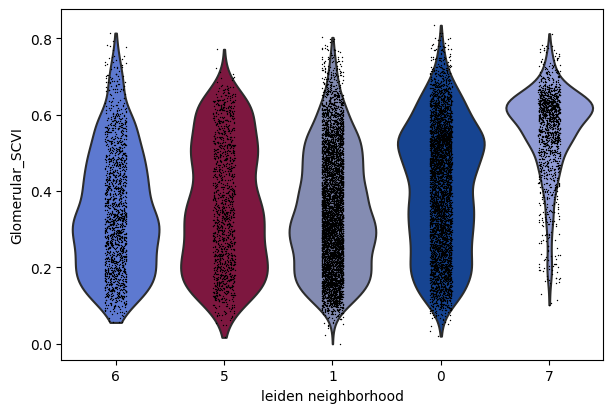

In [6]:
adataPT = adata[adata.obs["cellType_SCANVI"] == "PT"]
groupby_order = ["10","7","0","1","8"]

sc.pl.violin(adataPT, keys="Glomerular_SCVI", groupby="leiden_neighborhood", order=groupby_order)


In [7]:
def Plot_4_lineages_neighborhoodType(neighborhood_Name, adata):
    model = GAM(s(0,spline_order=3,n_splines = 6), distribution='normal', max_iter=2000, fit_intercept=True,  tol=0.001, verbose=False)
    
    x_param = 'PseudoTime_SCVI' 
    lineage_1 = 'LOH_absorbtion_SCVI'
    lineage_2 = 'PT_absorbtion_SCVI'
    lineage_3 = 'DCT_absorbtion_SCVI'
    lineage_4 = 'Podo_absorbtion_SCVI'
    quantile_max = 0.95
    
    adata.obs["neighborhood"] = (adata.obs["leiden_neighborhood"] == neighborhood_Name)
    adata.obs["neighborhood"] = adata.obs["neighborhood"].astype(int)

    ###
    latent_max_1 = adata[adata.obs[lineage_1] >= 0.9].obs[x_param].quantile(quantile_max)
    adata_plot_1 = adata[adata.obs[x_param] < latent_max_1]
    
    X1 = adata_plot_1.obs[[x_param]].to_numpy()
    y1 = adata_plot_1.obs[["neighborhood"]]
    w1 = adata_plot_1.obs[lineage_1].to_numpy()

    model1 = model
    model1.fit(X1,y1,w1)
    XX1 = np.linspace(0, latent_max_1, 500)
    y_pred1 = model1.predict(XX1)

    ###
    latent_max_2 = adata[adata.obs[lineage_2] >= 0.9].obs[x_param].quantile(quantile_max)
    adata_plot_2 = adata[adata.obs[x_param] < latent_max_2]

    X2 = adata_plot_2.obs[[x_param]].to_numpy()
    y2 = adata_plot_2.obs[["neighborhood"]]
    w2 = adata_plot_2.obs[lineage_2].to_numpy()

    model2 = model
    model2.fit(X2,y2,w2)
    XX2 = np.linspace(0, latent_max_2, 500)
    y_pred2 = model2.predict(XX2)

    ###
    latent_max_3 = adata[adata.obs[lineage_3] >= 0.9].obs[x_param].quantile(quantile_max)
    adata_plot_3 = adata[adata.obs[x_param] < latent_max_3]
    
    X3 = adata_plot_3.obs[[x_param]].to_numpy()
    y3 = adata_plot_3.obs[["neighborhood"]]
    w3 = adata_plot_3.obs[lineage_3].to_numpy()

    model3 = model
    model3.fit(X3,y3,w3)
    XX3 = np.linspace(0, latent_max_3, 500)
    y_pred3 = model3.predict(XX3)

    ###
    latent_max_4 = adata[adata.obs[lineage_4] >= 0.9].obs[x_param].quantile(quantile_max)
    adata_plot_4 = adata[adata.obs[x_param] < latent_max_4]

    X4 = adata_plot_4.obs[[x_param]].to_numpy()
    y4 = adata_plot_4.obs[["neighborhood"]]
    w4 = adata_plot_4.obs[lineage_4].to_numpy()

    model4 = model
    model4.fit(X4,y4,w4)
    XX4 = np.linspace(0, latent_max_4, 500)
    y_pred4 = model4.predict(XX4)
    ###

    plt.plot(XX1, y_pred1, color='red', label='LOH')
    plt.plot(XX2, y_pred2, color='blue', label='PT')
    plt.plot(XX3, y_pred3, color='black', label='DCT')
    plt.plot(XX4, y_pred4, color='darkorange', label='Podocyte')
    
    plt.title(neighborhood_Name)

    plt.xlim(0, 0.8)
    plt.show()

/tmp/ipykernel_151214/1849460523.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["neighborhood"] = (adata.obs["leiden_neighborhood"] == neighborhood_Name)
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**

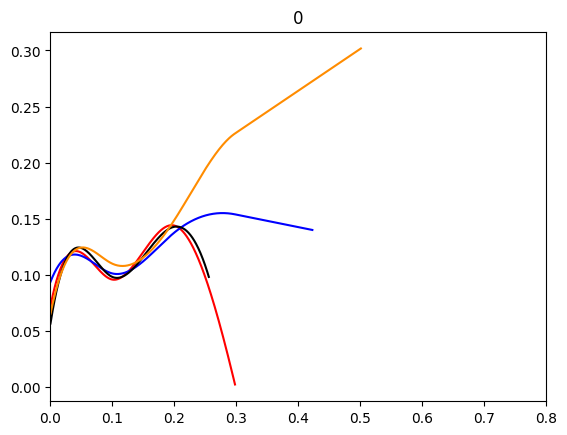

/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWar

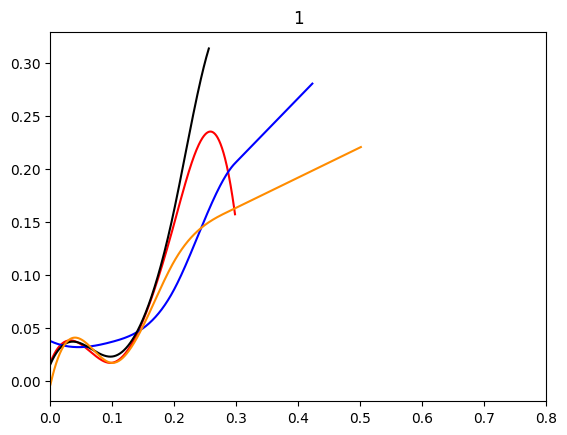

/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWar

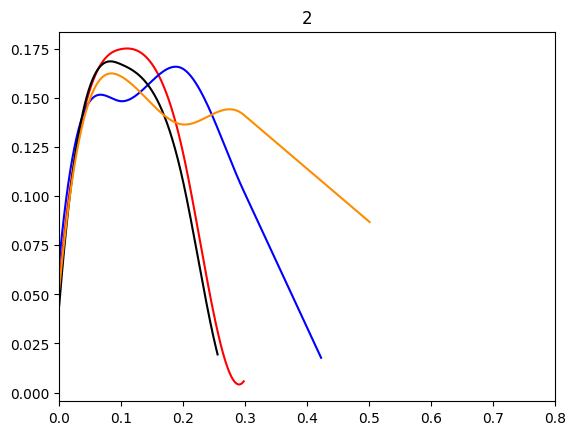

/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWar

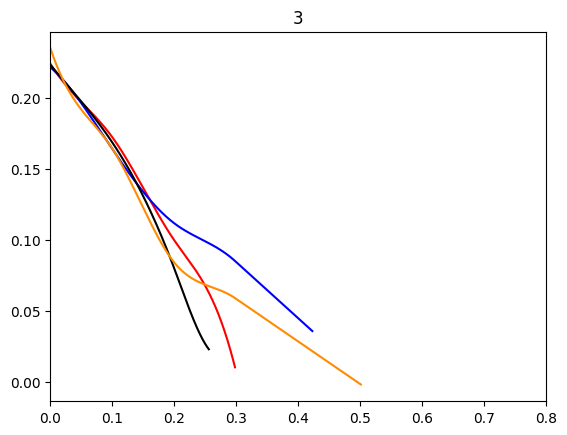

/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWar

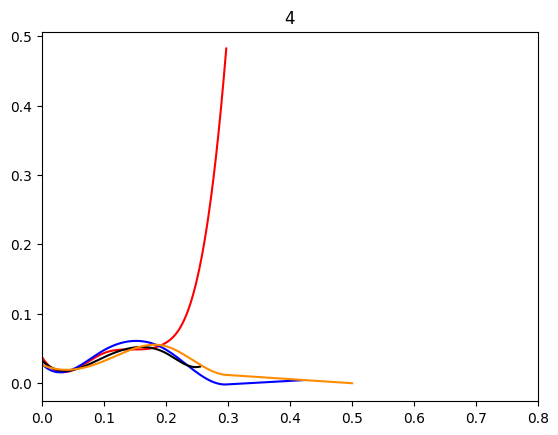

/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWar

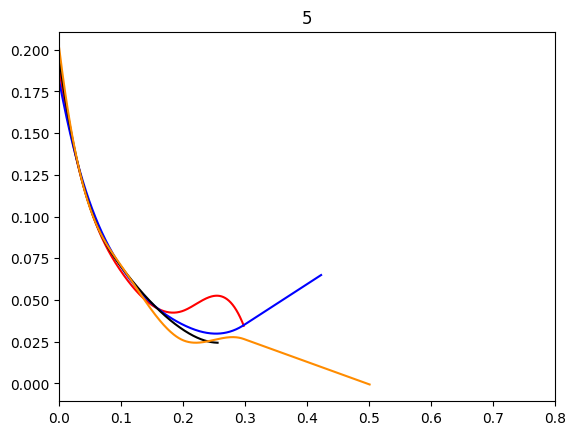

/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWar

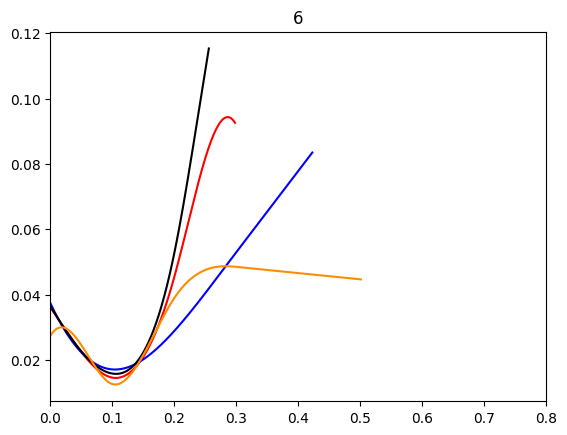

/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWar

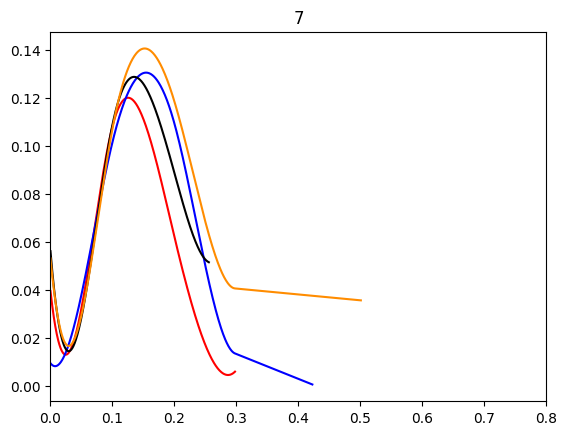

/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWar

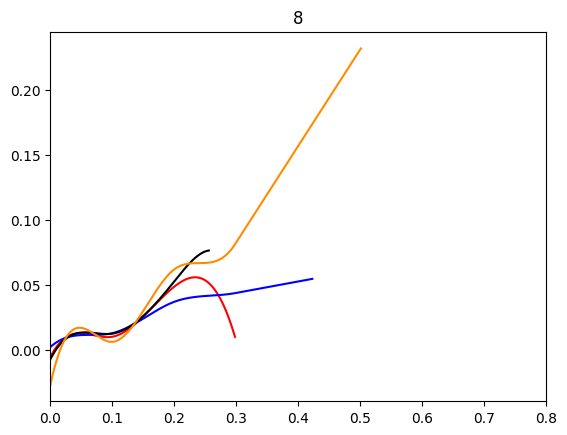

/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWar

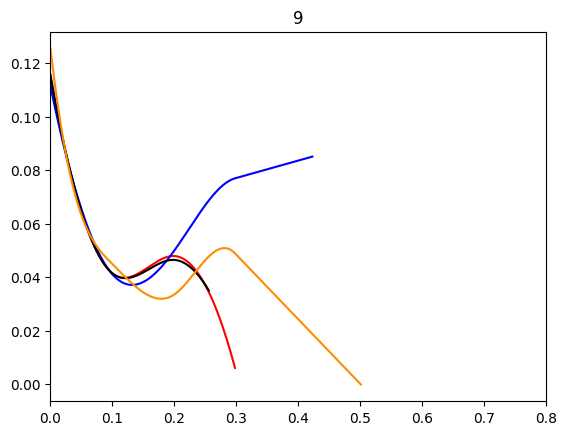

/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWar

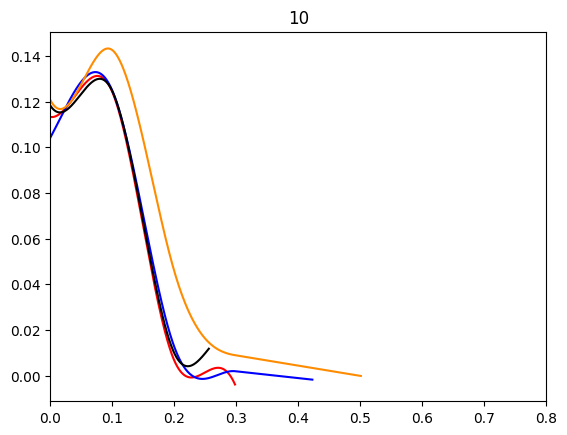

/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWar

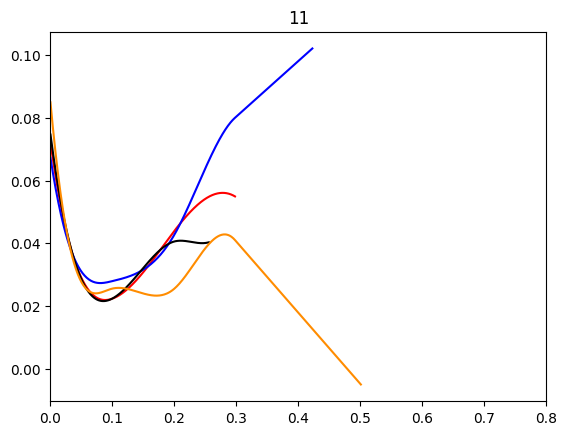

/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWar

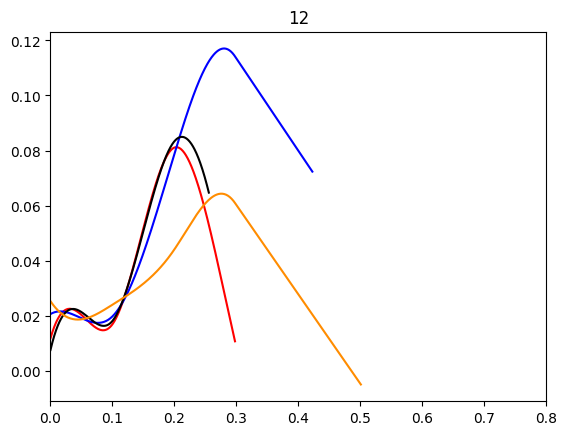

/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWar

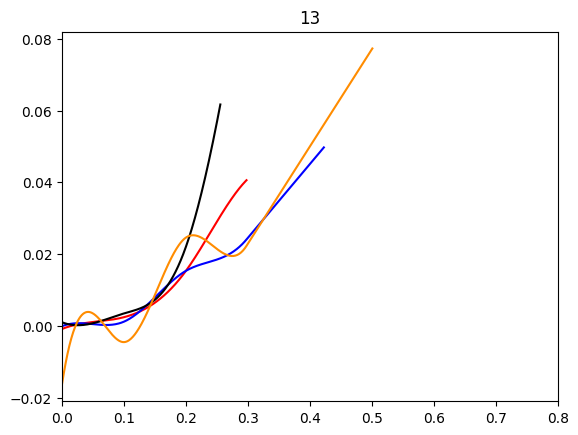

/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWar

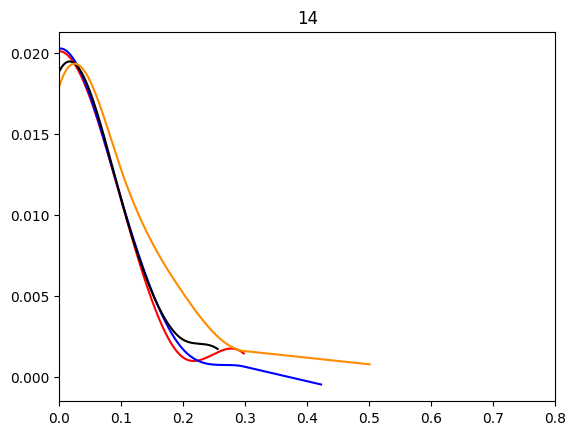

/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWar

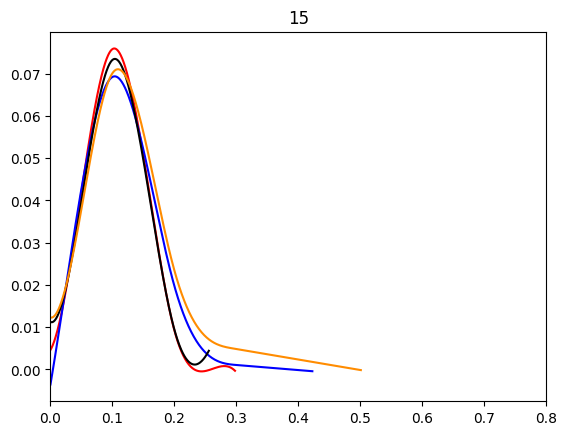

/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:593: RuntimeWarning: divide by zero encountered in reciprocal
  weights ** -1)**-0.5)
/usr/local/lib/python3.8/dist-packages/pygam/distributions.py:146: RuntimeWarning: divide by zero encountered in divide
  scale = self.scale / weights
/usr/local/lib/python3.8/dist-packages/pygam/pygam.py:1112: RuntimeWar

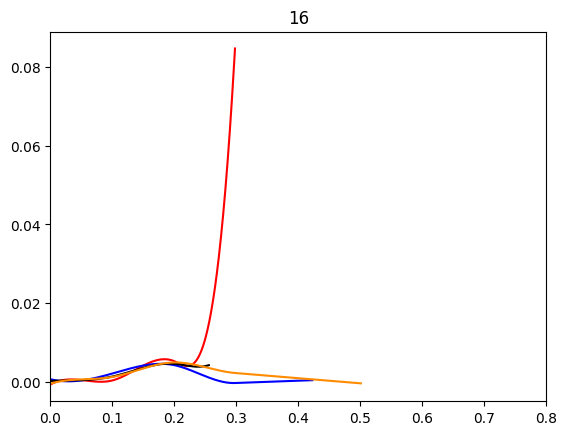

In [8]:
Plot_4_lineages_neighborhoodType("0", adata)
Plot_4_lineages_neighborhoodType("1", adata)
Plot_4_lineages_neighborhoodType("2", adata)
Plot_4_lineages_neighborhoodType("3", adata)
Plot_4_lineages_neighborhoodType("4", adata)
Plot_4_lineages_neighborhoodType("5", adata)
Plot_4_lineages_neighborhoodType("6", adata)
Plot_4_lineages_neighborhoodType("7", adata)
Plot_4_lineages_neighborhoodType("8", adata)
Plot_4_lineages_neighborhoodType("9", adata)
Plot_4_lineages_neighborhoodType("10", adata)
Plot_4_lineages_neighborhoodType("11", adata)
Plot_4_lineages_neighborhoodType("12", adata)
Plot_4_lineages_neighborhoodType("13", adata)
Plot_4_lineages_neighborhoodType("14", adata)
Plot_4_lineages_neighborhoodType("15", adata)
Plot_4_lineages_neighborhoodType("16", adata)

